---
## Step 0: Load The Data, standard imports, globals declared

In [40]:
import tensorflow as tf
import numpy as np
BATCH_SIZE = 128
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data
import os
cwd = os.getcwd()
training_file =  cwd + '/traffic-signs-data/train.p'
validation_file= cwd + '/traffic-signs-data/valid.p'
testing_file =   cwd + '/traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Dataset Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [111]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

# TODO: Number of training examples
n_train = X_train.shape[0]

# TODO: Number of validation examples
n_validation = X_valid.shape[0]

# TODO: Number of testing examples.
n_test = X_test.shape[0]

# TODO: What's the shape of an traffic sign image?
image_shape = X_train.shape[1:]

# TODO: How many unique classes/labels there are in the dataset.
n_classes = max(y_train) + 1 #Assuming training has at least 1 example of each.

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 55017
Number of testing examples = 12630
Image data shape = (32, 32, 1)
Number of classes = 43.0


### Visualizations

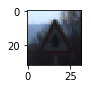

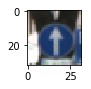

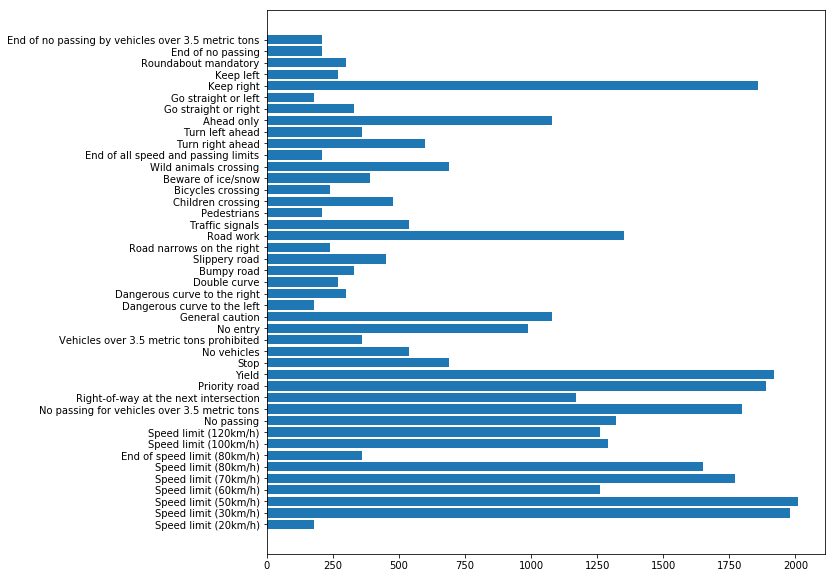

Mean Examples/class: 809.279069767
Median Examples/class: 540.0
Max Examples/class 2010
Min Examples/class 180


In [42]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
import numpy as np
# Visualizations will be shown in the notebook.
%matplotlib inline

random_image = X_train[np.random.randint(0,X_train.shape[0])]
plt.figure(figsize=(1,1))
plt.imshow(random_image)

random_image2 = X_train[np.random.randint(0,X_train.shape[0])]
plt.figure(figsize=(1,1))
plt.imshow(random_image2)


with open(cwd + '/signnames.csv', mode='r', encoding='utf-8') as f:
    label_classes = f.readlines()
classes = [s.split(',')[1].replace('\n','') for s in label_classes][1:]
ypos = np.arange(len(classes))

y_counts = [(y_train == i).sum() for i in range(n_classes)]

plt.figure(figsize=(10,10))
plt.barh(ypos, y_counts)
plt.yticks(ypos, classes)
plt.show()
print("Mean Examples/class:", np.mean(y_counts))
print("Median Examples/class:", np.median(y_counts))
print("Max Examples/class", np.max(y_counts))
print("Min Examples/class", np.min(y_counts))



----

## Model Architecture

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. Although, computing the mean is easy enough anyway.

Images are converted to grayscale as the only other pre-processing step.


In [112]:
def rgb2grayscale(X):
    import cv2
    gray = np.zeros((len(X), 32,32,1), dtype=np.float32)
    for i in range(0, len(X)):
        gray[i] = cv2.cvtColor(X[i], cv2.COLOR_RGB2GRAY).reshape(32,32,1)
    return gray


In [44]:
#Convert to grayscale
X_train = rgb2grayscale(X_train)
X_valid = rgb2grayscale(X_valid)
X_test  = rgb2grayscale(X_test)

# Visualize the averages of the classes

This compute the average per pixel activation image for each class. The average is actually quite nicely centered and clearly marked. Some of the higher detailed signs are less clear. E.G. No Passing and Vehicles over 3.5 metcis tones prohibited are not easily distinguishable

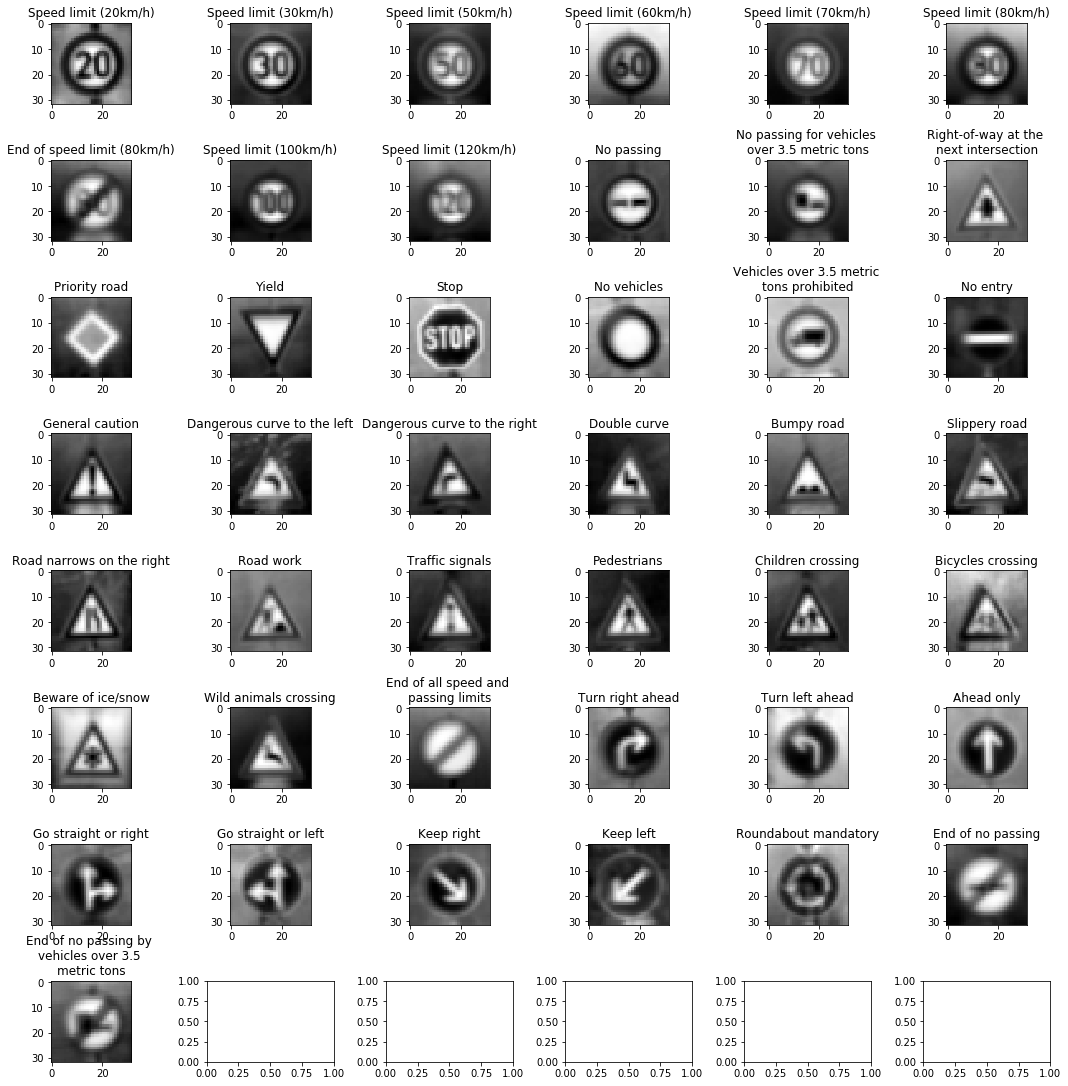

In [45]:
avg_image = np.zeros([43,32,32])
for i in range(n_classes):
    num_in_class = np.sum(y_train == i)
    #print(num_in_class_i)
    X_in_class = X_train[y_train == i]
    #print(X_in_class.shape)
    X_avg = np.sum(X_in_class, axis=0) / num_in_class
    #print(X_avg.shape)
    avg_image[i] = np.squeeze(X_avg)

formatted_classes = classes
formatted_classes[10] = 'No passing for vehicles \nover 3.5 metric tons'
formatted_classes[11] = 'Right-of-way at the \nnext intersection'
formatted_classes[16] = 'Vehicles over 3.5 metric \ntons prohibited'
formatted_classes[32] = 'End of all speed and \npassing limits'
formatted_classes[42] = 'End of no passing by \nvehicles over 3.5 \nmetric tons'

f, axarr = plt.subplots(8,6)
f.set_figheight(15)
f.set_figwidth(15)
f.tight_layout(pad=1.0, w_pad=1.5, h_pad=3.5)
for i in range(8):
    for j in range(6):
        index = i*6 + j
        if(index+1 > n_classes):
            break
        axarr[i,j].imshow(avg_image[index], cmap='gray')
        axarr[i,j].set_title(formatted_classes[index])

In [46]:
# Normalize
mean = np.mean(X_train)
X_train = (X_train - mean)/128.0
X_valid = (X_valid - mean)/128.0
X_test = (X_test - mean)/128.0

In [48]:
#increase number of examples for lower exampled classes
X_tr = X_train
print(X_tr.shape)
y_tr = y_train

y_counts = [(y_tr == i).sum() for i in range(n_classes)]
while min(y_counts) < 500:
    for c in range(n_classes):
        num_ex = sum(y_train == c)
        if num_ex < 1000:
            examples = np.array(X_train[y_train == c])
            examples += np.random.normal(0, 0.0001, examples.shape)
            #print(examples.shape, num_ex)
            X_tr = np.concatenate((X_tr, examples), axis=0)
            #print("new X_tr", X_tr.shape)
            y_tr = np.concatenate((y_tr, (np.ones(num_ex) * c)), axis=0)
            #print("new y_tr", y_tr.shape)
    y_counts = [(y_tr == i).sum() for i in range(n_classes)]
#print(min(y_counts))

(34799, 32, 32, 1)


In [49]:
#Sanity the data is the same structure
assert len(X_tr) == len(y_tr)
if len(X_tr) == len(y_tr):
    X_train = X_tr
    y_train = y_tr
print("X-train", X_train.shape)
print("y_train", y_train.shape)

X-train (55017, 32, 32, 1)
y_train (55017,)


In [50]:
def model(X):
    mu = 0.0 
    sigma = 0.25
    padding = 'VALID'
    kernel1 = 12
    kernel2 = 24
    
    #Conv1
    W1 = tf.Variable(tf.truncated_normal([5,5,1,kernel1], mean=mu, stddev=sigma))
    b1 = tf.Variable(tf.zeros(kernel1))
    stride1 = [1,1,1,1]
    conv1 = tf.nn.conv2d(x, W1, stride1, padding)
    conv1 = tf.nn.bias_add(conv1, b1)
    
    act1 = tf.nn.relu(conv1)
    
    pool1 = tf.nn.max_pool(act1, [1,2,2,1], [1,2,2,1], padding=padding)
    print(pool1.get_shape())
    
    
    #conv2
    W2 = tf.Variable(tf.truncated_normal([5,5,kernel1,kernel2], mean=mu, stddev=sigma))
    b2 = tf.Variable(tf.zeros(kernel2))
    stride2 = [1,1,1,1]
    conv2 = tf.nn.conv2d(pool1, W2, stride2, padding)
    conv2 = tf.nn.bias_add(conv2, b2)
    
    act2 = tf.nn.relu(conv2)
    pool2 = tf.nn.max_pool(act2, [1,2,2,1], [1,2,2,1], padding=padding)
    print('pool2', pool2.get_shape())
    
    #Dense 1
    flatten1 = tf.reshape(pool2, [-1, 5*5*kernel2])
    dropout = tf.nn.dropout(flatten1, keep_prob)
    
    W3 = tf.Variable(tf.truncated_normal([5*5*kernel2, 400], mean=mu, stddev=sigma))
    b3 = tf.Variable(tf.zeros(400))
    dense1 = tf.matmul(dropout, W3)
    dense1 = tf.nn.bias_add(dense1, b3)
    act3 = tf.nn.relu(dense1)
    
    #Dense 2
    dropout2 = tf.nn.dropout(act3, keep_prob)
    W4 = tf.Variable(tf.truncated_normal([400, 120], mean=mu, stddev=sigma))
    b4 = tf.Variable(tf.zeros(120))
    dense2 = tf.matmul(dropout2, W4)
    dense2 = tf.nn.bias_add(dense2, b4)
    act4 = tf.nn.relu(dense2)
    
    #Dense 3
    W5 = tf.Variable(tf.truncated_normal([120, 84], mean=mu, stddev=sigma))
    b5 = tf.Variable(tf.zeros(84))
    dense3 = tf.matmul(act4, W5)
    dense3 = tf.nn.bias_add(dense3, b5)
    act5 = tf.nn.relu(dense3)
    
    #Dense 4
    W6 = tf.Variable(tf.truncated_normal([84, 43], mean=mu, stddev=sigma))
    b6 = tf.Variable(tf.zeros(43))
    dense4 = tf.matmul(act5, W6)
    logits = tf.nn.bias_add(dense4, b6)
    
    return logits

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [51]:
#Place holders
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32)
one_hot_y = tf.one_hot(y, 43)

In [52]:
rate = 0.008 #This rate had a large effect on training, this only sometimes converges, possibly we'll need to restart
             # 0.01 diverged quickly after 90% accuracy on validation
             # 0.001 fails top converge always

logits = model(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)

loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

(?, 14, 14, 12)
pool2 (?, 5, 5, 24)


In [53]:
index = tf.argmax(logits, 1)
correct_prediction = tf.equal(index, tf.argmax(one_hot_y, 1))
prediction = tf.cast(index, tf.float32)
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
        pred = sess.run(index, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        #print(pred)
    #print("Accurate out of Num Examples",total_accuracy, num_examples)
    #print("Guess", pred)
    #tf.Print(prediction, [prediction], message="Guess Number")
    return total_accuracy / num_examples

In [54]:
from sklearn.utils import shuffle
EPOCHS = 75
X_train, y_train = shuffle(X_train, y_train)
max_valid_acc = 0
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})
            
        validation_accuracy = evaluate(X_valid, y_valid)
        train_accuracy = evaluate(X_train[0:len(y_valid)], y_train[0:len(y_valid)])
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print("Train Accuracy = {:.3f}".format(train_accuracy))
        if(validation_accuracy > max_valid_acc):
            max_valid_acc = validation_accuracy
            print("Saving best seen model on epoch #{}".format(i+1))
            #New best model, save this one.
            saver.save(sess, './traffic_signs_extradata')        
    #saver.save(sess, './traffic_signs_extradata')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.027
Train Accuracy = 0.059
Saving best seen model on epoch #1
EPOCH 2 ...
Validation Accuracy = 0.052
Train Accuracy = 0.118
Saving best seen model on epoch #2
EPOCH 3 ...
Validation Accuracy = 0.331
Train Accuracy = 0.358
Saving best seen model on epoch #3
EPOCH 4 ...
Validation Accuracy = 0.431
Train Accuracy = 0.468
Saving best seen model on epoch #4
EPOCH 5 ...
Validation Accuracy = 0.549
Train Accuracy = 0.630
Saving best seen model on epoch #5
EPOCH 6 ...
Validation Accuracy = 0.705
Train Accuracy = 0.759
Saving best seen model on epoch #6
EPOCH 7 ...
Validation Accuracy = 0.773
Train Accuracy = 0.860
Saving best seen model on epoch #7
EPOCH 8 ...
Validation Accuracy = 0.786
Train Accuracy = 0.840
Saving best seen model on epoch #8
EPOCH 9 ...
Validation Accuracy = 0.821
Train Accuracy = 0.888
Saving best seen model on epoch #9
EPOCH 10 ...
Validation Accuracy = 0.843
Train Accuracy = 0.907
Saving best seen model on epoch #10
EPOCH

# Testing on new images

## Found images

These images were pulled from Google Street View in the city of Frankfurt.

They were originally pulled as 24x24 (oops) images and scaled up to 32x32

In [93]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

custom_train_file_X =   cwd + '/traffic-signs-data/X_test.p'
custom_train_file_y =   cwd + '/traffic-signs-data/y_test.p'

with open(custom_train_file_X, mode='rb') as f:
    custom_X_test = np.array(pickle.load(f, encoding='latin1'))
with open(custom_train_file_y, mode='rb') as f:
    custom_y_test = np.array(pickle.load(f, encoding='latin1'))
    


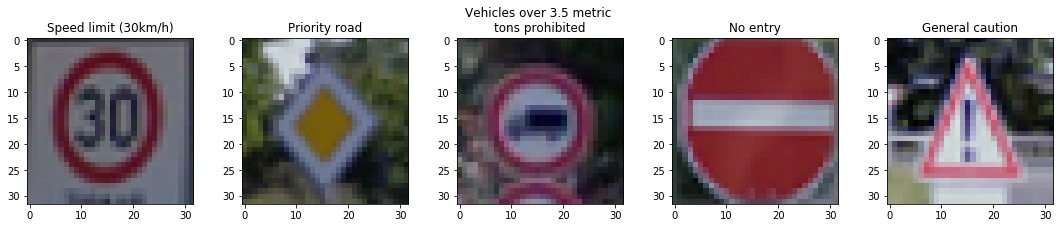

In [94]:
f, axarr = plt.subplots(1,5)
f.set_figheight(15)
f.set_figwidth(15)
f.tight_layout(pad=1.0, w_pad=1.5, h_pad=3.5)
for i in range(5):
    axarr[i].imshow(custom_X_test[i,:])
    axarr[i].set_title(formatted_classes[custom_y_test[i]])

### Predict the Sign Type for Each Image

In [95]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.
custom_X_test = rgb2grayscale(custom_X_test)
custom_X_test = (custom_X_test - mean)/128.0

In [97]:
saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, './traffic_signs_extradata')
    test_accuracy = evaluate(custom_X_test, custom_y_test)
    predicts = sess.run(index, feed_dict={x: custom_X_test, y: custom_y_test, keep_prob: 1.0})

INFO:tensorflow:Restoring parameters from ./traffic_signs_extradata
[ 1 12 16 17 18]
1.0


### Analyze Performance

Got 100.0% of the custom test set correct


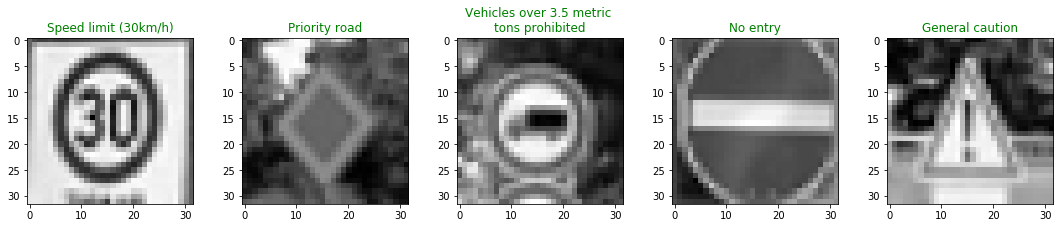

In [104]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.'
print('Got {0}% of the custom test set correct'.format(test_accuracy*100))

f, axarr = plt.subplots(1,5)
f.set_figheight(15)
f.set_figwidth(15)
f.tight_layout(pad=1.0, w_pad=1.5, h_pad=3.5)
for i in range(5):
    color = 'r'
    im = np.squeeze(custom_X_test[i,:])
    axarr[i].imshow(im, cmap='gray')
    if(custom_y_test[i] == predicts[i]):
        color = 'g'
    axarr[i].set_title(formatted_classes[custom_y_test[i]], color=color)
    
#custom_y_test

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tf.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [110]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.


saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, './traffic_signs_extradata')
    top_k_pred = sess.run(tf.nn.top_k(logits, k=5), feed_dict={x: custom_X_test, y: custom_y_test, keep_prob: 1.0})

print("(Actual, Top 5)")
for ans in zip(custom_y_test, top_k_pred.indices):
    print(ans)

INFO:tensorflow:Restoring parameters from ./traffic_signs_extradata
(Actual, Top 5)
(1, array([1, 2, 5, 4, 0], dtype=int32))
(12, array([12, 15,  0, 40,  4], dtype=int32))
(16, array([16, 12,  9, 39, 31], dtype=int32))
(17, array([17, 14, 12, 23, 25], dtype=int32))
(18, array([18, 27, 26, 25, 11], dtype=int32))


---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [ ]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")